# Logistisk Regresjon

La oss fortsette med det klassiske datasettet som inneholder data om størrlsen (lende og bredde) av begerbladene (engelsk: sepal) (de ytre bladene i en blomst) og kronbladene (engelsk: petal) til tre ulike type Iris (setosa, versicolor og virginica) - på norsk hhv.: vill iris, praktiris og blått flagg iris). Vi skal bruke dette datasettet til å se nærmere på logistisk regresjon. Først må vi importere noen pakker og lese inn datasettet.

Dette er helt identisk med det vi gjorde for lineær regresjons!

In [1]:
from sklearn.datasets import load_iris

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.stats import expon
import math

Datasettet er tilgjengelig direkte fra ScikitLearn

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

Nå er typen iris lagret som 0, 1 og 2. Vi vil gjerne oversette dette til faktiske navn slik at vi ikke glemmer hva de ulike tallene betyr. Dette kan vi gjøre på flere måter, men en mulighet er å bruke såkalte lambda-funksjoner som utfører en test av hvert enkelt element in en kolonne. 

In [4]:
df['species'] = df['target'].apply(lambda x: "setosa" if x == 0.0 else ("versicolor" if x == 1.0 else "virginica"))

In [5]:
df.tail()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target    species  
145     2.0  virginica  
146     2.0  virginica  
147     2.0  virginica  
148     2.0  virginica  
149     2.0  virginica

Det er keitete å ha kolonnenavn som inneholder mellomrom så la oss lage nye enklere navn. Når vi setter *inplace=True* betyr det at data-framen df automatisk blir oppdatert med de nye kolonnenavnene. Hvis ikke må man bruke *df = df.rename()* for at endringene skal bli oppdatert.

In [6]:
df.rename({'sepal length (cm)': 'sepal_length'}, axis='columns',inplace=True)
df.rename({'sepal width (cm)': 'sepal_width'}, axis='columns',inplace=True)
df.rename({'petal length (cm)': 'petal_length'}, axis='columns',inplace=True)
df.rename({'petal width (cm)': 'petal_width'}, axis='columns',inplace=True)
df.head()

sepal_length  sepal_width  petal_length  petal_width  target species
0           5.1          3.5           1.4          0.2     0.0  setosa
1           4.9          3.0           1.4          0.2     0.0  setosa
2           4.7          3.2           1.3          0.2     0.0  setosa
3           4.6          3.1           1.5          0.2     0.0  setosa
4           5.0          3.6           1.4          0.2     0.0  setosa

## Forberedelser til logistisk regresjon

I eksempelet med lineær regresjon så vi på om det var en lineær sammenheng mellom lengden og bredden til de to ulike typene blader for en type iris. I dette eksempelet skal vi se om vi ut fra målinger av bredde og/eller lengde til bladene kan avgjøre hvilken type iris vi ser på. Det betyr at responsen ikke lengre er kvantitativ (dvs. lengde/bredde til bladene) men kvantitative/kategoriske (dvs. blomsten er enten iris setosa, versicolor eller virginica). For kategoriske data er logistisk regresjon en egnet metode. 

Før vi setter igang med å lage modellen la oss se på dataene og vurdere om modellen vår vil klare å skille mellom de ulike typene iris basert på størrelsen til bladene. En fin måte å vurdere dette på er ved bruk av såkalte [box-plot](https://en.wikipedia.org/wiki/Box_plot). Feks. kan vi se på fordelingen av bredde og lengde på begerbladene for de tre ulike typene iris.

Boxplot gir et godt overblikk over spredningen i målingene vi har i datasettes vårt.

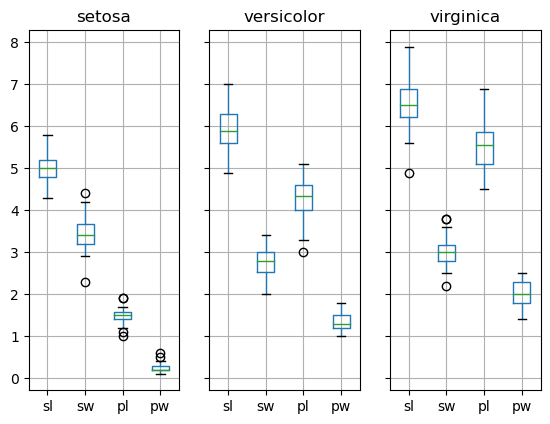

In [7]:
ax = df.groupby("species").boxplot(column=["sepal_length","sepal_width","petal_length","petal_width"],layout=(1,3),return_type="axes")
# La oss forkorte navnene slik at plottene blir mer leselig
labels = ["sl","sw","pl","pw"]
for a in ax:
    a.set_xticklabels(labels)

Siden vi ønsker å lage en modell som kan predikere hvilken type iris vi har med å gjøre ønsker vi at fordelingen til variablene for de ulike irisiene er så forksjellig som mulig. Det beste vil selvsagt være å bruke alle målingene og det skal vi se på senere, men la oss først bruke kun en variabel. Jeg velger å se på *petal width (pw)* 


La os se på et scatter-plot for lengde og bredde på kronbladene for de ulike typene iris

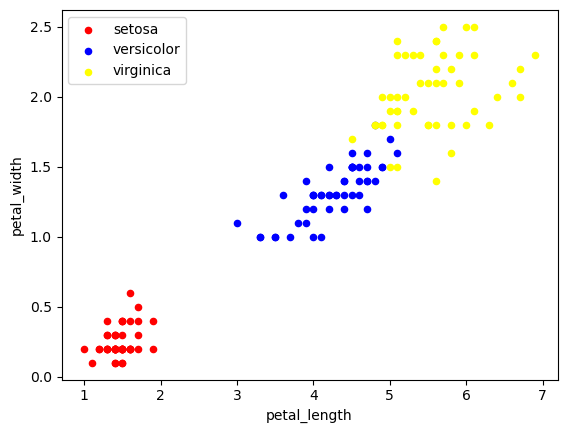

In [8]:
fig, ax = plt.subplots()
colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'yellow' }
for t in df['species'].unique():
    df[df["species"] == t].plot.scatter(x="petal_length",y="petal_width",c=colors[t],ax=ax,label=t)
plt.legend()

Ved første øyekast ser det ut disse to variablene er ganske forskjellig for alle de tre ulike typene iris.

Tenk deg at du skulle tegnet tre vertikale streker som skulle definere de ulike områdene for de tre iris-typene. Det er mulig å plassere strekene slik at vi får relativt høy overvekt av en bestemt type iris i området definert av hver strek. Type noe slikt (enda bedre om vi hadde brukt y-aksen i tillegg - altså effektivt en 2-dimensjonal logistisk regresjon):

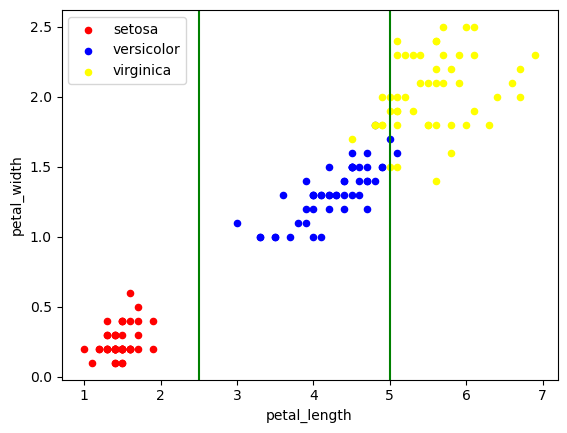

In [9]:
fig, ax = plt.subplots()
colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'yellow' }
for t in df['species'].unique():
    df[df["species"] == t].plot.scatter(x="petal_length",y="petal_width",c=colors[t],ax=ax,label=t)
plt.axvline(x = 2.5,color="green")
plt.axvline(x = 5.0,color="green")
plt.legend()

La oss avslutte denne seksjonen med å beskrive problemet vi ønsker å undersøke. Vi vil altså finne ut sannsynligheten for at irisen er av typen versicolor eller setosa gitt lengden på kronbladet, eller

$$P(Y = versicolor | \text{lengde på kronblad})$$

Dette er altså en sansynlighet for at blomsten er en iris versicolor. Det betyr at P må ha verdier mellom 0 og 1. Det er ganske åpenbart at lineær regresjon ikke fungerer godt i slike tilfeller. La oss bare kjapt illustrere dette ved å bruke lineær regresjon (dette burde være godt kjent fra tidligere).

Når vi skal starte med å lage en modell som kan si om en blomst er iris setosa eller iris versicolor bare basert på lengden til kronbladene (petal). Vi trekker derfor ut dette som Y (respons) og X (predikator) til modellen vår. 

Vi bruker *target* kolonnen som sier at hvis det er en **iris setosa er target 0** mens **target lik 1 betyr versicolor**. Dette betyr at respons-vektoren vår kan ta to verdier, 0 dersom  blomstent er av type setosa og 1 dersom blomsten er av typen versicolor. Matematisk kan vi representere dette slik


$$Y = \begin{cases}
    1, & \text{hvis } \texttt{versicolor}.\\
    0, & \text{hvis } \texttt{setosa}.
  \end{cases}$$

Vi henter dette ut fra pandas dataframen vår direkte og konverterer til numpy-arrays:

In [10]:
# Trekk ut målingene til lengden av kronbladene til hhv. iris setosa og iris versicolor
X = df[(df["target"] == 0) | (df["target"] == 1)].petal_length.to_numpy()
Y = df[(df["target"] == 0) | (df["target"] == 1)].target.to_numpy()
X = X[:, np.newaxis]
Y = Y[:, np.newaxis]

Definer en lineær regresjonsmodell

In [11]:

#Y = Y[:, np.newaxis]
clf = LinearRegression().fit(X,Y)
print("Coefficient = %.2f"%clf.coef_)
print("Intercept = %.2f"%clf.intercept_)
print("Score/R^2 = %.2f"%clf.score(X,Y))

Coefficient = 0.34
Intercept = -0.46
Score/R^2 = 0.94


In [12]:
# Definer en x-vektor som dekker datapunktene (i dette tilfellet mellom 4 og 7 cm)
X_plot = np.linspace(0, 6, 300)
# Lag så responsfunksjonen ved å bruke parameterne fra modellen vår
fit = clf.intercept_[0] + clf.coef_[0]*X_plot

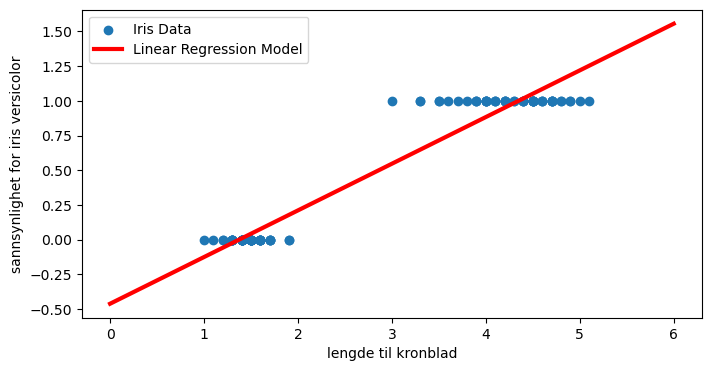

In [13]:
plt.figure(1, figsize=(8, 4))
plt.clf()
plt.scatter(X, Y,label="Iris Data")
plt.plot(X_plot, fit, label="Linear Regression Model", color="red", linewidth=3)
plt.xlabel("lengde til kronblad")
plt.ylabel("sannsynlighet for iris versicolor")
plt.legend()

For små kronbladlengder blir sannsynligheten negativ, og for veldig lange kronblad blir sansynligheten større enn 1! Dette er ikke et unikt eksempel. I alle tilfeller hvor vi prøver å tilpasse en lineær funksjon til en binær (0 eller 1) respons vil vil alltid predikere sannsynligheter $ >1 $ og $ < 0$ - dersom ikke verdiene til x er begrenset på noen måte.

## Logistisk funksjon

I logistisk regresjon trenger vi altså en funksjon som gir verdier mellom 0 og 1 for alle verider av $X$. Det er mange funksjoner som oppfyller dette kravet, men i logistisk regresjon bruker vi en såkalt *logistisk funksjon* definert som:

$$ p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 x}} $$

som er ett (av mange) eksempler på en *sigmoid*-funksjon. La oss ta en titt på hvordan den ser. Først definerer vi en funskjon i python, ```def logistic()```, som returnerer den *logistisk funksjonen* når vi gir den de to parameterne samt en X-vektor.

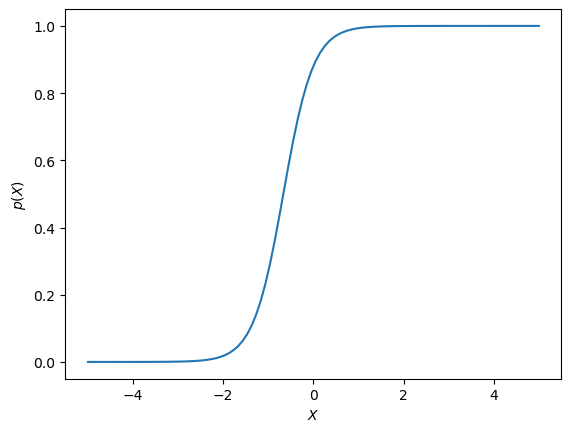

In [14]:
def logistic(beta_0, beta_1, X): 
    return np.exp(beta_0 + beta_1*X)/(1+np.exp(beta_0 + beta_1*X))

x = np.linspace(-5, 5, 100)
# beta0 = 2, beta1 = 3
y = logistic(2, 3, x)
plt.plot(x, y)
plt.xlabel(r"$X$")
plt.ylabel(r"$p(X)$")
plt.savefig("logistic.svg")

Som vi ser gir denne funksjonen et tall mellom 0 og 1 for alle $X$. Det er litt mindre intuitivt hvilken effekt $\beta_0$ og $\beta_1$ har på denne funksjonen sammenlignet med det vi så for den lineære funksjonen vi brukte i lineær regresjon. La oss derfor se hvordan den logistiske funksjonen endrer seg med parametrene: 

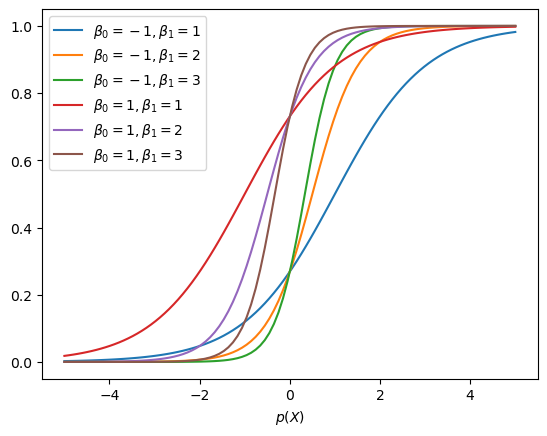

In [15]:
### Auto-utforsk
beta0s = [-1, 1]
beta1s = [1, 2, 3]

for beta0 in beta0s: 
    for beta1 in beta1s:
        x = np.linspace(-5, 5, 100)
        y = logistic(beta0, beta1, x)
        plt.plot(x, y, label=rf"$\beta_0 = {beta0}, \beta_1 = {beta1}$")
plt.legend()
plt.xlabel(r"$X$")
plt.xlabel(r"$p(X)$")
plt.savefig("logistic_variation.svg")

Eller på en enda morsommere måte:

In [16]:
from ipywidgets import interactive
#import matplotlib.pyplot as plt
import numpy as np

def f(beta0, beta1):
    x = np.linspace(-5, 5, num=1000)
    plt.plot(x, logistic(beta0, beta1, x))
    plt.ylim(-0.1, 1.1)

interactive_plot = interactive(f, beta0=(-3.0, 3.0), beta1=(-3, 3, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='beta0', max=3.0, min=-3.0), FloatSlider(value=0.0, d…

Basert på disse plottene kan vi gjøre følgende observasjoner:

1. $\beta_0$ flytter vendepunktet (den bratte delen av funksjonen) fram og tilbake langs $x$.
1. $\beta_1$ styrer hvor bratt funksjonen er 
1. posisjonen til vendepunktet er avhengig av både og $\beta_0$ og $\beta_1$

## Forberedelser til logistisk regresjon

Nå som vi har etablert en passende funksjon til å bruke i logistisk regresjon kan vi starte med å se hvordan vi kan bruke dette til å forutsi hvilken type iris vi har med å gjøre bare basert på lengden på kronbaldene.

I likhet med da vi gjorde lineær regresjon må vi gi X-vektoren (predikatoren) vår en ekstra dimensjon for at vi skal kunne bruke scikit-learn sin implementering av LogisticRegression.

In [17]:
#X = X[:, np.newaxis]

In [18]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

/scratch2/eirikgr/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=100000.0)

Siden vi vet hva hver blomst er klassifisert som kan vi sjekke modellen vår og se hvor ofte den klassifiserer riktig og feil. Her antar modellen at alle X som gir $P(X) > 0.5$ betyr at blomsten klassifiseres som *versicolor* mens alle X som gir $P(X) < 0.5$ klassifiseres som *setosa*. Det er kanskje ikke en optimal inndeling. Vi skal diskutere dette mer senere.

In [19]:
pred = logreg.predict(X)
correct = 0
wrong = 0
for i in range(len(pred)):
    if pred[i] == Y[i]:
        correct += 1
    else:
        wrong += 1
print("Klassifiserte riktig %i ganger og feil %i ganger. Treffprosent = %.0f%%"%(correct,wrong,100.*(correct)/(correct+wrong)))

Klassifiserte riktig 100 ganger og feil 0 ganger. Treffprosent = 100%


Vi kan hente ut parameterne samt $R^2$ direkte fra modellen

In [20]:
print("beta0 = %.2f"%logreg.coef_)
print("beta1 = %.2f"%logreg.intercept_)
print("Score/R^2 = %.2f"%logreg.score(X,Y))

beta0 = 16.62
beta1 = -41.17
Score/R^2 = 1.00


Og vi kan plotte funksjonen

In [21]:
logfunc = logistic(logreg.intercept_[0],logreg.coef_[0],X_plot)

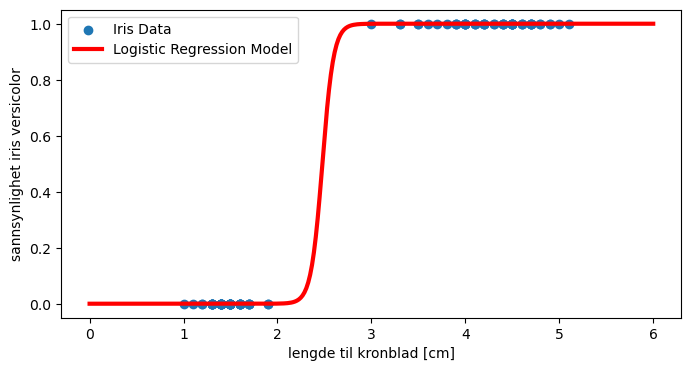

In [22]:
plt.figure(1, figsize=(8, 4))
plt.clf()
plt.scatter(X, Y,label="Iris Data")
plt.plot(X_plot, logfunc, label="Logistic Regression Model", color="red", linewidth=3)
plt.xlabel("lengde til kronblad [cm]")
plt.ylabel("sannsynlighet iris versicolor")
plt.legend()

Vi kan bruke modellen til å se på sannsynligheten for at blomsten er hhv. versicolor og setosa for en gitt måling av lengden på kronbladet ($X$). 

In [23]:
v = np.ones((1, 1))

In [24]:
v

array([[1.]])

F.eks: si at vi måler $x = 2.4$. Hvor sansynlig er det at dette er en iris versicolor. Funksjonen ```predict_proba()``` returnerer sannsynligheten for iris setosa (target = 0) som første element og sannsynligheten for iris versicolor (target = 1) som andre element i en array:

In [25]:
logreg.predict_proba(v*5.4)

array([[0., 1.]])

La oss plotte alt i samme plot

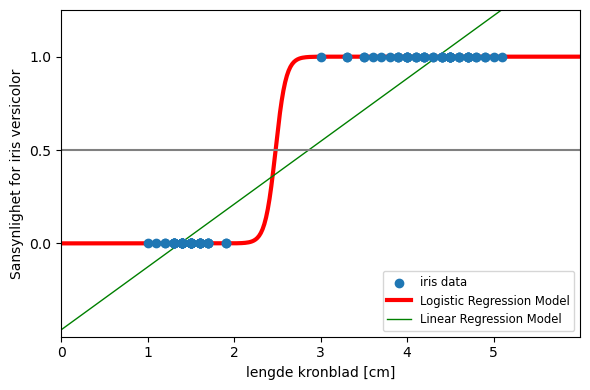

In [26]:
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.scatter(X[:,0], Y, label="iris data", zorder=20)
#plt.scatter(X_train[:,0], y_train, label="train data", color="green",marker='.', zorder=20)
X_plot = np.linspace(0, 6, 300)

loss = expit(X_plot * logreg.coef_ + logreg.intercept_).ravel()
plt.plot(X_plot, logfunc, label="Logistic Regression Model", color="red", linewidth=3)

# lineær modell
plt.plot(
    X_plot,
    clf.coef_[0] * X_plot + clf.intercept_[0],
    label="Linear Regression Model",
    linewidth=1,
    color="green"
)

plt.axhline(0.5, color=".5")

plt.ylabel("Sansynlighet for iris versicolor")
plt.xlabel("lengde kronblad [cm]")
plt.xticks(range(0, 6))
plt.yticks([0, 0.5, 1])
plt.ylim(-0.5, 1.25)
plt.xlim(0, 6)
plt.legend(
    loc="lower right",
    fontsize="small",
)
plt.tight_layout()
plt.show()

In [27]:
i = 0
odds = np.linspace(0, 7, 300)
for x in X_plot:
    odds[i] = math.exp(loss[i])
    #if i > 5: break
    i += 1

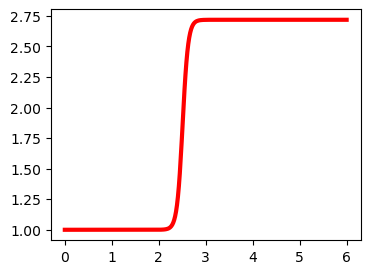

In [28]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(X_plot, odds, label="Logistic Regression Model", color="red", linewidth=3)

# Multiple (multi) logistisk regresjon

Selvom modellen vi laget over viste seg å være ganske god til å klassifisere iris, la oss prøve å bruke alle målingene vi har i datasetts til å lage en multi logistisk regresjon. Det er får endringer som trengs for å få til dette. Vi vil altså bruke følgende funksjon

$$ p(X) = \frac{e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4}}{1+e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4}}$$

Vi har nå 4 predikatorer $\{X_1,X_2,X_3,X_4\}$ og en parameter per predikator (\${\beta_1,\beta_2,\beta_3,\beta_4\}$) som vi nå skal estimere på samme måte som vi gjorde over for kun en predikator.

Først lager vi en 4-dimensjonal numpy-vektor fra kolonnene i data framen. Y-vektoren kan være den samme som over (vi holder oss fortsatt til binær klassifikasjon (setosa eller versicolor)):

In [29]:
# Lage en liste med navnene til alle predikatorene
predictors = ["sepal_length","sepal_width","petal_length","petal_width"]
X = df[(df["target"] == 0) | (df["target"] == 1)][predictors].values
Y = df[(df["target"] == 0) | (df["target"] == 1)].target.to_numpy()

In [30]:
multilogreg = LogisticRegression(C=1e5)
multilogreg.fit(X, Y)

LogisticRegression(C=100000.0)

In [31]:
multilogreg.coef_.shape

(1, 4)

In [32]:
print("beta0 = %.2f"%multilogreg.intercept_)
for i in range(len(multilogreg.coef_[0])):
    print("beta%i (%-12s) = %+4.2f"%(i+1,predictors[i],multilogreg.coef_[0][i]))
print("Score/R^2 = %.2f"%multilogreg.score(X,Y))

beta0 = -1.01
beta1 (sepal_length) = -1.84
beta2 (sepal_width ) = -6.24
beta3 (petal_length) = +9.86
beta4 (petal_width ) = +5.04
Score/R^2 = 1.00


Husk at dersom $\beta > 0$ så vil én økning i $X$ øke log(odds) med $\beta$. Dvs. at dersom $\beta$ er positiv vil en økning i $X$ gjøre at sannsynligheten blir større for at irisen er av type versicolor. Motsatt; dersom $\beta < 0$ vil en økning i $X$ minske sansynligheten for versicolor (altså øke sansynligheten for setosa). La oss sjekke om dette gir mening ved å se på variablene i et scatterplot. 

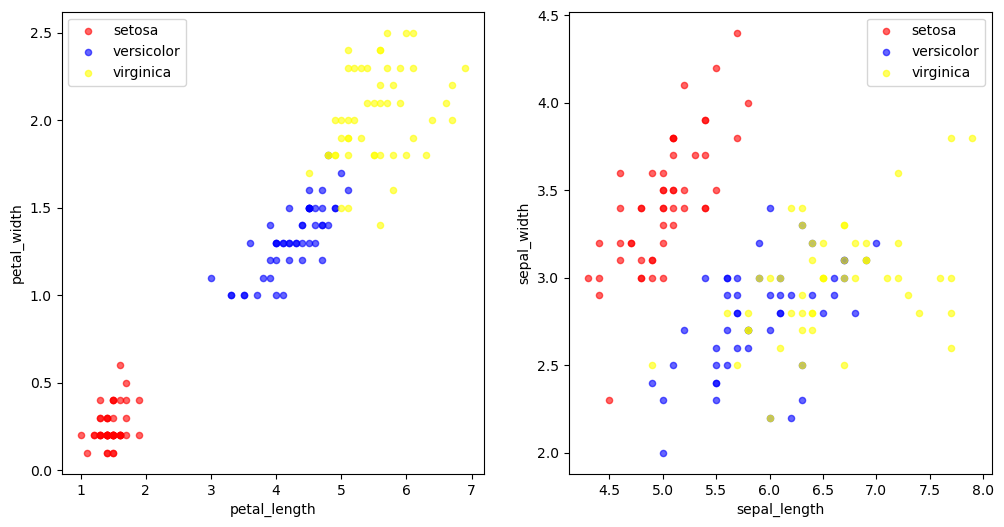

In [33]:
# Putt plottene ved siden av hverandre
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'yellow' }
for t in df['species'].unique():
    # Argumentet ax = ax[0] eller ax[1] definerer hvilke ramme vi vil plotte i.
    df[df["species"] == t].plot.scatter(x="petal_length",y="petal_width",c=colors[t],ax=ax[0],label=t,alpha=0.6)
    df[df["species"] == t].plot.scatter(x="sepal_length",y="sepal_width",c=colors[t],ax=ax[1],label=t,alpha=0.6)
plt.legend()

# Multinomial (multinomisk) logistisk regresjon

La oss prøve å legge til en tredje kategori for å lage den ultimate *iris-type* modellen. Vi kan velge om vi vil bruke *one-vs-rest* implementeringen (hvor vi velger en baseline-kategori) eller om vi bruker *softmax*. Vi ser først på det siste tilfellet. Den logistiske funksjonen vår for k = 1,2,3 ser nå slik ut

$$ p(Y=k|X=x) = \frac{e^{\beta_{k0} + \beta_{k1} x_1 + \beta_{k2} x_2 + \beta_{k3} x_3 + \beta_{k4} x_4}}{\sum_{l=1}^{3}\left(e^{\beta_{l0} + \beta_{l1} x_1 + \beta_{l2} x_2 + \beta_{l3} x_3 + \beta_{l4} x_4}\right)}$$


I følge dokumentasjonen til *LogisticRgeression()* i scikit learn oppnår vi dette ved å sette argumentet ```multi_class = "multinomial"```. Men først må vi utvide X- og Y-vektorene vår med den siste typen iris.

In [34]:
X = df[predictors].values
Y = df.target.to_numpy()

In [35]:
multinomreg = LogisticRegression(C=1e5,multi_class = "multinomial")
multinomreg.fit(X, Y)

LogisticRegression(C=100000.0, multi_class='multinomial')

Koeffisientene til modellen vår har nå 3 koeffisenter for hver av de 4 predikatorene:

In [36]:
multinomreg.coef_.shape

(3, 4)

In [37]:
multinomreg.intercept_

array([  2.15237727,  20.21907037, -22.37144764])

In [38]:
x = df[df["target"]==2].sample()[predictors].values[0]
x

array([7.3, 2.9, 6.3, 1.8])

In [42]:
print("beta0 = %.2f, %.2f, %.2f"%(multinomreg.intercept_[0],multinomreg.intercept_[1],multinomreg.intercept_[2]))
for i in range(len(multinomreg.coef_[0])):
    print("beta%i (%-12s) = %+4.2f"%(i+1,predictors[i],multinomreg.coef_[0][i]))
print("Score/R^2 = %.2f"%multinomreg.score(X,Y))

beta0 = 2.15, 20.22, -22.37
beta1 (sepal_length) = +3.93
beta2 (sepal_width ) = +9.18
beta3 (petal_length) = -12.37
beta4 (petal_width ) = -5.93
Score/R^2 = 0.99


In [43]:
# La oss velge en tilfeldig måling av setosa, for å sjekke om odd-ratioen blir veldig stor

# catogory 1: versicolor
k = 1
# catogory 0: setosa
kp = 0
logpred = multinomreg.intercept_[k]-multinomreg.intercept_[kp]
for i in range(multinomreg.coef_.shape[1]-1):
    logpred += (multinomreg.coef_[i][k]-multinomreg.coef_[i][kp])*x[i]
logpred

25.06723552870938